# Extracting the Reddit data of Climate Discussion Contributors 

Calling the PushshiftAPI with queries related to climate change opinion, we extract data from Reddit submissions and comments.

In [1]:
import os
from pathlib import Path
import datetime

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

from psaw import PushshiftAPI
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", UserWarning)

## 1) Call Reddit API (PushshiftAPI)

For finding the data for our network, we will call the PushshiftAPI in order to obtain data from reddit submissions and comments.

In [2]:
api = PushshiftAPI()

### 1.1) Retrieving Reddit submissions
Since we use the Twitter Climate Sentiment dataset ([link1](https://github.com/edwardcqian/climate_change_sentiment) and [link2](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset) for training a sentiment classification model, we will make use of the same queries as they used for collecting that dataset.

In [3]:
# define search conditions
queries = ['climate change  climate',
           'global warming  climate',
           'warming planet  climate']
 
# define time interval
start_date = int(datetime.datetime(2014, 11, 1).timestamp())
end_date = int(datetime.datetime(2022, 4, 5).timestamp())

# parameters to modify extend of data retrieval
limit = 250
num_intervals = 10848

We specify the attributes that we want to keep for further analyses and continuously create a dataframe where duplicate rows are removed when all queries have been queried since there is potentially quite a lot of overlap in the context of the queries as they are all related to climate change.

In [4]:
def select_attributes(attributes, results):
    temp = []
    for my_submission in results:
        temp_dict = {}
        for att in attributes:
            try:
                temp_dict[att] = my_submission.d_[att]
            except KeyError:
                temp_dict[att] = np.nan
        temp.append(temp_dict)
    return temp

In [5]:
# specify attributes of interest
attributes = ['id', 'author', 'title', 'selftext', 'score', 'created_utc', 'subreddit', 'num_comments', 'all_awardings', 'awarders', 'total_awards_received']
df_submissions = pd.DataFrame()

# search API for submissions
date_linspace = np.linspace(start_date, end_date, num_intervals, dtype=np.int64)

for i in tqdm(range(1, date_linspace.__len__())):
    # define parameters
    date1 = date_linspace[i-1]
    date2 = date_linspace[i]
    results = []

    # query all queries
    for j, query in enumerate(queries):
        gen = api.search_submissions(after=date1,
                                     before=date2,
                                     q=query,
                                     limit=limit)
        temp_results = list(gen)
        results += temp_results
        
        if temp_results.__len__() == limit:
            print(f"Limit exceeded at index {i, j}")
    
    # create structure for dataframe (nested loop because 2014 data does not have awards)
    sub4df = select_attributes(attributes, results)
    
    # create dataframe continuously
    temp_df = pd.DataFrame.from_dict(sub4df)
    df_submissions = pd.concat([df_submissions, temp_df])
    
    # drop the duplicated ids
    df_submissions = df_submissions.drop_duplicates('id', keep='first')

# reset index    
df_submissions = df_submissions.reset_index(drop=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Limit exceeded at index (1, 0)
Limit exceeded at index (1, 1)
Limit exceeded at index (1, 2)
Limit exceeded at index (2, 0)
Limit exceeded at index (2, 1)
Limit exceeded at index (2, 2)
Limit exceeded at index (3, 0)
Limit exceeded at index (3, 1)
Limit exceeded at index (3, 2)
Limit exceeded at index (4, 0)
Limit exceeded at index (4, 1)
Limit exceeded at index (4, 2)


In [6]:
print(f"Are all duplicates removed? {df_submissions.id.is_unique}")

Are all duplicates removed? True


All duplicates are gone - nice!

Let's continue by modifying the dataframe a little bit and obtain the date.

In [7]:
# modify dataframe
df_submissions['date'] = df_submissions['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).date())
df_submissions = df_submissions.drop('created_utc', axis=1)

print(f"Shape of dataframe: {df_submissions.shape}")
df_submissions.head()

Shape of dataframe: (114, 11)


,id,author,title,selftext,score,subreddit,num_comments,all_awardings,awarders,total_awards_received,date
0,51u2py,[deleted],Obama on Climate Change: The Trends Are ‘Terri...,[deleted],0,politics,1,NaN,NaN,NaN,2016-09-08
1,51u0nm,m2b2,Few months ago I watched a video about climate...,,0,AskReddit,2,NaN,NaN,NaN,2016-09-08
2,51u0ln,ell_computer,California Just Took a Huge Step in the Fight ...,,1,news_etc,0,NaN,NaN,NaN,2016-09-08
3,51tsvn,feelinglikeasir,Climate Change Solution?,What if we dug out large artificial rivers run...,4,climatechange,13,NaN,NaN,NaN,2016-09-08
4,51tofi,ell_computer,Obama on 'Terrifying' Threat of Climate Change,,1,news_etc,0,NaN,NaN,NaN,2016-09-08


In [8]:
# save dataframe as a pickle
path = Path(os.getcwd()).parent
df_submissions.to_pickle(path / 'data/reddit_submissions.bz2')

### 1.2) Retrieving Reddit comments

Based on the submissions that we extracted in 1.1, we will now extract Reddit comments. This is done similarly using functions from the `PushshiftAPI`-module.

In [9]:
# search API for comments
results = []
limit = 25 

for i, submission in tqdm(df_submissions.iterrows(), total=df_submissions.__len__()):
    gen = api.search_comments(subreddit=submission.subreddit,
                              link_id=submission.id, 
                              size=limit)
    temp_results = list(gen)
    results += temp_results
    
    if temp_results.__len__() == limit:
        print(f"Limit exceeded at index {idx}")

  0%|          | 0/114 [00:00<?, ?it/s]

We are only interested in keeping some of the information associated to a comment on Reddit. This is extracted and turned into a DataFrame below.

In [10]:
# specify attributes of interest
attributes = ['id', 'link_id', 'score', 'created_utc', 'author', 'parent_id', 'body', 'controversiality', 'total_awards_received', 'all_awardings', 'associated_award']

# create dataframe
sub4df = select_attributes(attributes, results)
df_comments = pd.DataFrame.from_dict(sub4df)

In [11]:
# modify dataframe
df_comments.rename(columns={'link_id':'submission_id', 'body':'text'}, inplace=True)
df_comments['date'] = df_comments['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).date())
df_comments = df_comments.drop('created_utc', axis=1)

print(f"Shape of dataframe: {df_comments.shape}")
df_comments.head()

Shape of dataframe: (1526, 11)


,id,submission_id,score,author,parent_id,text,controversiality,total_awards_received,all_awardings,associated_award,date
0,d7mss1j,t3_51tsvn,1,fishsticks40,t1_d7fadvs,&gt; It is not about whether or not the planet...,0.0,NaN,NaN,NaN,2016-09-14
1,d7ftt9d,t3_51tsvn,2,eggplantsforall,t1_d7fadvs,Our secret CO2 teleportation scheme has been d...,0.0,NaN,NaN,NaN,2016-09-09
2,d7fadvs,t3_51tsvn,0,ILOVEFISHANDCHIPS,t1_d7evpuc,If we manage to teleport CO2 beyond the edge o...,1.0,NaN,NaN,NaN,2016-09-09
3,d7evpuc,t3_51tsvn,1,feelinglikeasir,t3_51tsvn,"Not to mention creation of jobs, infrastructur...",0.0,NaN,NaN,NaN,2016-09-08
4,d7ev52a,t3_51tsvn,1,mnixxon,t3_51tsvn,This won't work. The only thing that can stop...,0.0,NaN,NaN,NaN,2016-09-08


In [14]:
# save dataframe as a pickle
path = Path(os.getcwd()).parent
df_comments.to_pickle(path / 'data/reddit_comments.bz2')

## 2) Analyzing the Reddit data

### 2.1) Submissions

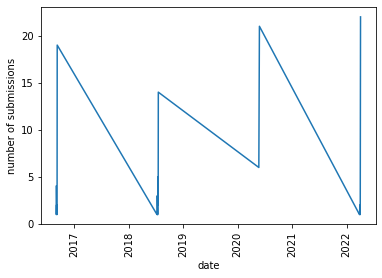

In [15]:
# plotting number of submission per day
df_submissions.groupby(by='date').size().plot()
plt.xticks(rotation=90)
plt.ylabel('number of submissions')
plt.show()

In [16]:
print(f"Total number of submissions retrieved: {df_submissions.__len__()}")
print(f"Number of unique authors in retrieved submissions: {df_submissions.author.unique().__len__()}")

Total number of submissions retrieved: 114
Number of unique authors in retrieved submissions: 81


In [17]:
# mapping week number to dataframe
df_submissions['week'] = pd.Series([date.isocalendar()[1] for date in df_submissions.date])
df_submissions['year'] = pd.Series([date.isocalendar()[0] for date in df_submissions.date])

# create and show authors per week as a dataframe
author_week = pd.DataFrame(df_submissions.groupby(by=['year', 'week']).author.unique().apply(lambda x: x.__len__()))
author_week.rename(columns={'author':'num_authors'}, inplace=True)

author_week

num_authors
year week             
2016 35              2
     36             18
2018 28              8
     29             15
2020 21              2
     22             20
2022 13              6
     14             18

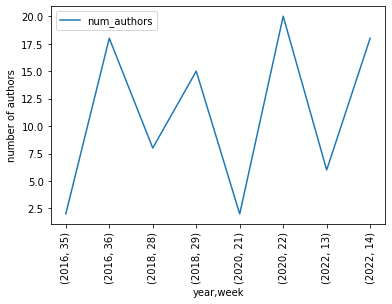

In [18]:
# plot authors per week
author_week.plot()
plt.ylabel('number of authors')
plt.xticks(rotation=90)
plt.show()

In [19]:
# awards
condition = np.logical_and(-df_submissions['total_awards_received'].isnull(), df_submissions['total_awards_received'] != 0)
df_submissions[condition]

,id,author,title,selftext,score,subreddit,num_comments,all_awardings,awarders,total_awards_received,date,week,year


### 2.2) Comments

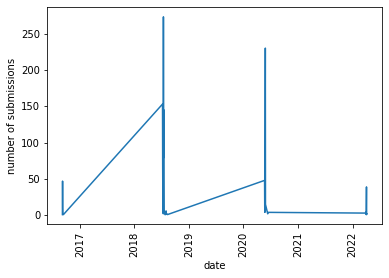

In [20]:
# plotting number of submission per day
df_comments.groupby(by='date').size().plot()
plt.xticks(rotation=90)
plt.ylabel('number of submissions')
plt.show()

In [21]:
print(f"Total number of submissions retrieved: {df_comments.__len__()}")
print(f"Number of unique authors in retrieved submissions: {df_comments.author.unique().__len__()}")

Total number of submissions retrieved: 1526
Number of unique authors in retrieved submissions: 652


In [22]:
# mapping week number to dataframe
df_comments['week'] = pd.Series([date.isocalendar()[1] for date in df_comments.date])
df_comments['year'] = pd.Series([date.isocalendar()[0] for date in df_comments.date])

# create and show authors per week as a dataframe
author_week = pd.DataFrame(df_comments.groupby(by=['year', 'week']).author.unique().apply(lambda x: x.__len__()))
author_week.rename(columns={'author':'num_authors'}, inplace=True)

author_week

num_authors
year week             
2016 36             41
     37              1
2018 28            179
     29            161
     30              4
     31              9
     32              4
2020 21             56
     22            182
     24              4
2022 13             11
     14             38

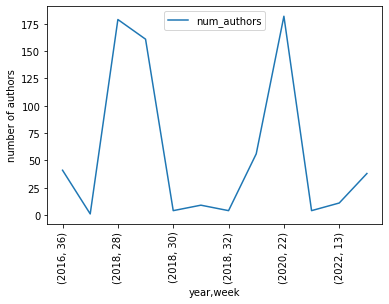

In [23]:
# plot authors per week
author_week.plot()
plt.ylabel('number of authors')
plt.xticks(rotation=90)
plt.show()

In [104]:
# awards
condition = np.logical_and(-df_comments['total_awards_received'].isnull(), df_comments['total_awards_received'] != 0)
df_comments[condition]

,id,submission_id,score,author,parent_id,text,controversiality,total_awards_received,all_awardings,associated_award,date,week,year
